# Analysis of the incidence of chickenpox

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

The data on the incidence of chickenpox illness are available from the Web site of the [Réseau Sentinelles](http://www.sentiweb.fr/). We download them as a file in CSV format, in which each line corresponds to a week in the observation period.

In [3]:
data_url = "https://www.sentiweb.fr/datasets/all/inc-7-PAY.csv"

It is preferable to first make a copy of the data, and then use that copy in the computational document. To ensure traceability of the data, the computational document must nevertheless contain the URL from which the data was obtained (which we have above). A reader can then download the data again and compare with the version used in the analysis. When publishing a computational document, the copy of the data is published as well, after verifying that republishing the data is legally possible. Below we make the local file with the data if it doesn't yet exist.

In [7]:
import urllib.request
import os
local_filename = "local_data.csv"

if not os.path.exists(local_filename):
    urllib.request.urlretrieve(data_url, local_filename)

data = pd.read_csv(local_filename, skiprows=1)
data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202519          7   4799     1358    8240       7           2   
1     202518          7   4795     2500    7090       7           4   
2     202517          7   6246     3424    9068       9           5   
3     202516          7   6151     3193    9109       9           5   
4     202515          7   5557     3262    7852       8           5   
5     202514          7   4984     2858    7110       7           4   
6     202513          7   5964     3608    8320       9           5   
7     202512          7   3855     1995    5715       6           3   
8     202511          7   5878     2747    9009       9           4   
9     202510          7   2921     1421    4421       4           2   
10    202509          7   3381     1468    5294       5           2   
11    202508          7   2835     1286    4384       4           2   
12    202507          7   4502     2382    6622       7           4   
13    202506          7   3455     1958    4952       5           3   
14    202505          7   2087     1056    3118       3           1   
15    202504          7   6895     4466    9324      10           6   
16    202503          7   2462     1161    3763       4           2   
17    202502          7   5966     2757    9175       9           4   
18    202501          7   6059     2451    9667       9           4   
19    202452          7   4356     1776    6936       7           3   
20    202451          7   4670     2239    7101       7           3   
21    202450          7   7363     4438   10288      11           7   
22    202449          7   6077     3631    8523       9           5   
23    202448          7   4189     1454    6924       6           2   
24    202447          7   1931      726    3136       3           1   
25    202446          7   2260      863    3657       3           1   
26    202445          7   2713     1216    4210       4           2   
27    202444          7   2135      676    3594       3           1   
28    202443          7   2124      641    3607       3           1   
29    202442          7   2621     1246    3996       4           2   
...      ...        ...    ...      ...     ...     ...         ...   
1767  199126          7  17608    11304   23912      31          20   
1768  199125          7  16169    10700   21638      28          18   
1769  199124          7  16171    10071   22271      28          17   
1770  199123          7  11947     7671   16223      21          13   
1771  199122          7  15452     9953   20951      27          17   
1772  199121          7  14903     8975   20831      26          16   
1773  199120          7  19053    12742   25364      34          23   
1774  199119          7  16739    11246   22232      29          19   
1775  199118          7  21385    13882   28888      38          25   
1776  199117          7  13462     8877   18047      24          16   
1777  199116          7  14857    10068   19646      26          18   
1778  199115          7  13975     9781   18169      25          18   
1779  199114          7  12265     7684   16846      22          14   
1780  199113          7   9567     6041   13093      17          11   
1781  199112          7  10864     7331   14397      19          13   
1782  199111          7  15574    11184   19964      27          19   
1783  199110          7  16643    11372   21914      29          20   
1784  199109          7  13741     8780   18702      24          15   
1785  199108          7  13289     8813   17765      23          15   
1786  199107          7  12337     8077   16597      22          15   
1787  199106          7  10877     7013   14741      19          12   
1788  199105          7  10442     6544   14340      18          11   
1789  199104          7   7913     4563   11263      14           8   
1790  199103          7  15387    10484   20290      27          18   
1791  199102          7  16277  

Are there missing data points?

In [8]:
data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Fortunately no!

Our dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [9]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [10]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and
the beginning of the next one, the difference should be zero, or very small.
We tolerate an error of one second.

This is OK except for one pair of consecutive periods between which
a whole week is missing.

We recognize the dates: it's the week without observations that we
have deleted earlier!

In [11]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

A first look at the data!

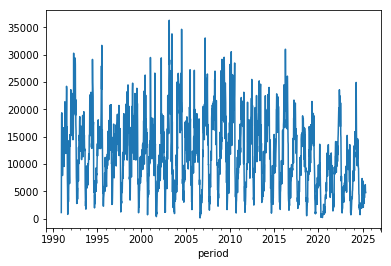

In [12]:
sorted_data['inc'].plot()

A zoom on the last few years shows more clearly that the peaks are situated in winter.

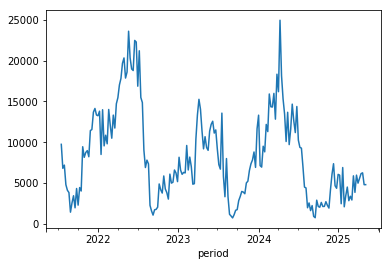

In [13]:
sorted_data['inc'][-200:].plot()

## Study of the annual incidence

As required by the exercise choose September 1st as the beginning of each annual period.

In [14]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

Starting from this list of weeks that contain September 1st, we obtain intervals of approximately one year as the periods between two adjacent weeks in this list. We compute the sums of weekly incidences for all these periods.

We also check that our periods contain between 51 and 52 weeks, as a safeguard against potential mistakes in our code.

In [16]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

And here are the annual incidences.

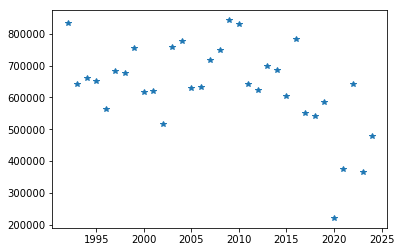

In [17]:
yearly_incidence.plot(style='*')

A sorted list makes it easier to find the highest values (at the end).

In [18]:
yearly_incidence.sort_values()

2020    221186
2023    366227
2021    376290
2024    479258
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2022    641397
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

So the strongest epidemic was in 2009 and the weakest in 2020.